## 🛠️ Importing Libraries

In [44]:
# Importing Libraries
import matplotlib.pyplot as plt  # For creating visualizations
import seaborn as sns  # For enhanced visualizations
import ast  # For safely evaluating strings as Python objects
import pandas as pd  # For data manipulation and analysis
from datasets import load_dataset  # For loading the dataset from Hugging Face
# Suppressing FutureWarnings to keep the output clean
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

## 📂 Loading the Dataset

In [45]:
# The dataset is loaded from Hugging Face's `datasets` library.
df = load_dataset('lukebarousse/data_jobs', split='train').to_pandas()

# Save the raw data to a CSV file for future use
df.to_csv('C:/Users/DELL/Job-Postings-Analysis/data/raw_data.csv', index=False)

## 🔄 Data Preparation

In [46]:
# Convert the 'job_skills' column from string to list
# The `job_skills` column contains strings that represent lists. We use `ast.literal_eval` to safely convert them.
df['job_skills'] = df['job_skills'].apply(lambda x: ast.literal_eval(x) if pd.notna(x) else x)

## 👀 Exploratory Data Analysis

In [ ]:
# Display the first few rows of the dataset
print("First 5 rows of the dataset:")
display(df.head())

# Check the shape of the dataset
print("\nShape of the dataset (rows, columns):")
print(df.shape)

# Check for missing values
print("\nMissing values in each column:")
print(df.isnull().sum())

First 5 rows of the dataset:


,job_title_short,job_title,job_location,job_via,job_schedule_type,job_work_from_home,search_location,job_posted_date,job_no_degree_mention,job_health_insurance,job_country,salary_rate,salary_year_avg,salary_hour_avg,company_name,job_skills,job_type_skills
0,Senior Data Engineer,Senior Clinical Data Engineer / Principal Clin...,"Watertown, CT",via Work Nearby,Full-time,False,"Texas, United States",2023-06-16 13:44:15,False,False,United States,None,NaN,NaN,Boehringer Ingelheim,None,None
1,Data Analyst,Data Analyst,"Guadalajara, Jalisco, Mexico",via BeBee México,Full-time,False,Mexico,2023-01-14 13:18:07,False,False,Mexico,None,NaN,NaN,Hewlett Packard Enterprise,"[r, python, sql, nosql, power bi, tableau]","{'analyst_tools': ['power bi', 'tableau'], 'pr..."
2,Data Engineer,"Data Engineer/Scientist/Analyst, Mid or Senior...","Berlin, Germany",via LinkedIn,Full-time,False,Germany,2023-10-10 13:14:55,False,False,Germany,None,NaN,NaN,ALPHA Augmented Services,"[python, sql, c#, azure, airflow, dax, docker,...","{'analyst_tools': ['dax'], 'cloud': ['azure'],..."
3,Data Engineer,LEAD ENGINEER - PRINCIPAL ANALYST - PRINCIPAL ...,"San Antonio, TX",via Diversity.com,Full-time,False,"Texas, United States",2023-07-04 13:01:41,True,False,United States,None,NaN,NaN,Southwest Research Institute,"[python, c++, java, matlab, aws, tensorflow, k...","{'cloud': ['aws'], 'libraries': ['tensorflow',..."
4,Data Engineer,Data Engineer- Sr Jobs,"Washington, DC",via Clearance Jobs,Full-time,False,Sudan,2023-08-07 14:29:36,False,False,Sudan,None,NaN,NaN,Kristina Daniel,"[bash, python, oracle, aws, ansible, puppet, j...","{'cloud': ['oracle', 'aws'], 'other': ['ansibl..."



Shape of the dataset (rows, columns):
(785741, 17)

Missing values in each column:
job_title_short               0
job_title                     1
job_location               1045
job_via                       8
job_schedule_type         12667
job_work_from_home            0
search_location               0
job_posted_date               0
job_no_degree_mention         0
job_health_insurance          0
job_country                  49
salary_rate              752674
salary_year_avg          763738
salary_hour_avg          775079
company_name                 18
job_skills               117037
job_type_skills          117037
dtype: int64


## 📈 2. Job Titles Distribution

Analyzing the distribution of job titles to identify the most in-demand roles in the dataset. We visualize the top 10 job titles using a horizontal bar plot.

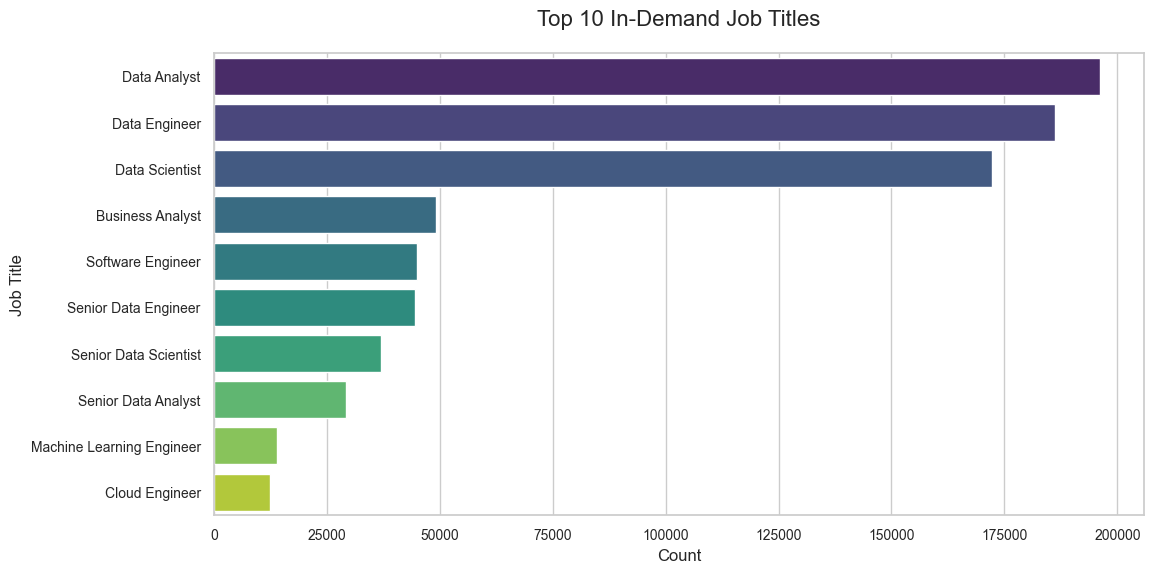

In [12]:
# Set the style for visualizations
sns.set(style="whitegrid")

# Create a horizontal bar plot for the top 10 job titles
plt.figure(figsize=(12, 6))
sns.countplot(
    y=df['job_title_short'],  # Use the 'job_title_short' column for the y-axis
    order=df['job_title_short'].value_counts().index[:10],  # Order by the top 10 most frequent job titles
    palette='viridis'  
)

# Add title and labels
plt.title('Top 10 In-Demand Job Titles', fontsize=16, pad=20)
plt.xlabel('Count', fontsize=12)
plt.ylabel('Job Title', fontsize=12)

# Improve tick labels
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Display the plot
plt.show()

## 💰 Average Salary for Top 10 Common Job Titles
This analysis aims to identify the highest-paying roles among the most common job titles in the dataset.

## 🔍1: Identify the Top 10 Most Common Job Titles

In [37]:
# Identify the top 10 most common job titles
top_jobs = df['job_title_short'].value_counts().index[:10]

## 📊 2: Filter Dataset for the Top 10 Job Titles

In [38]:
# Filter the dataset to include only the top 10 job titles
top_jobs_df = df[df['job_title_short'].isin(top_jobs)]

## 📈 3: Calculate the Mean Salary for Each Job Title

In [39]:
# Calculate the mean salary for each job title and sort in descending order
mean_salaries = top_jobs_df.groupby('job_title_short')['salary_year_avg'].mean().sort_values(ascending=False)

## 🎨 Visualization: Average Salary by Job Title

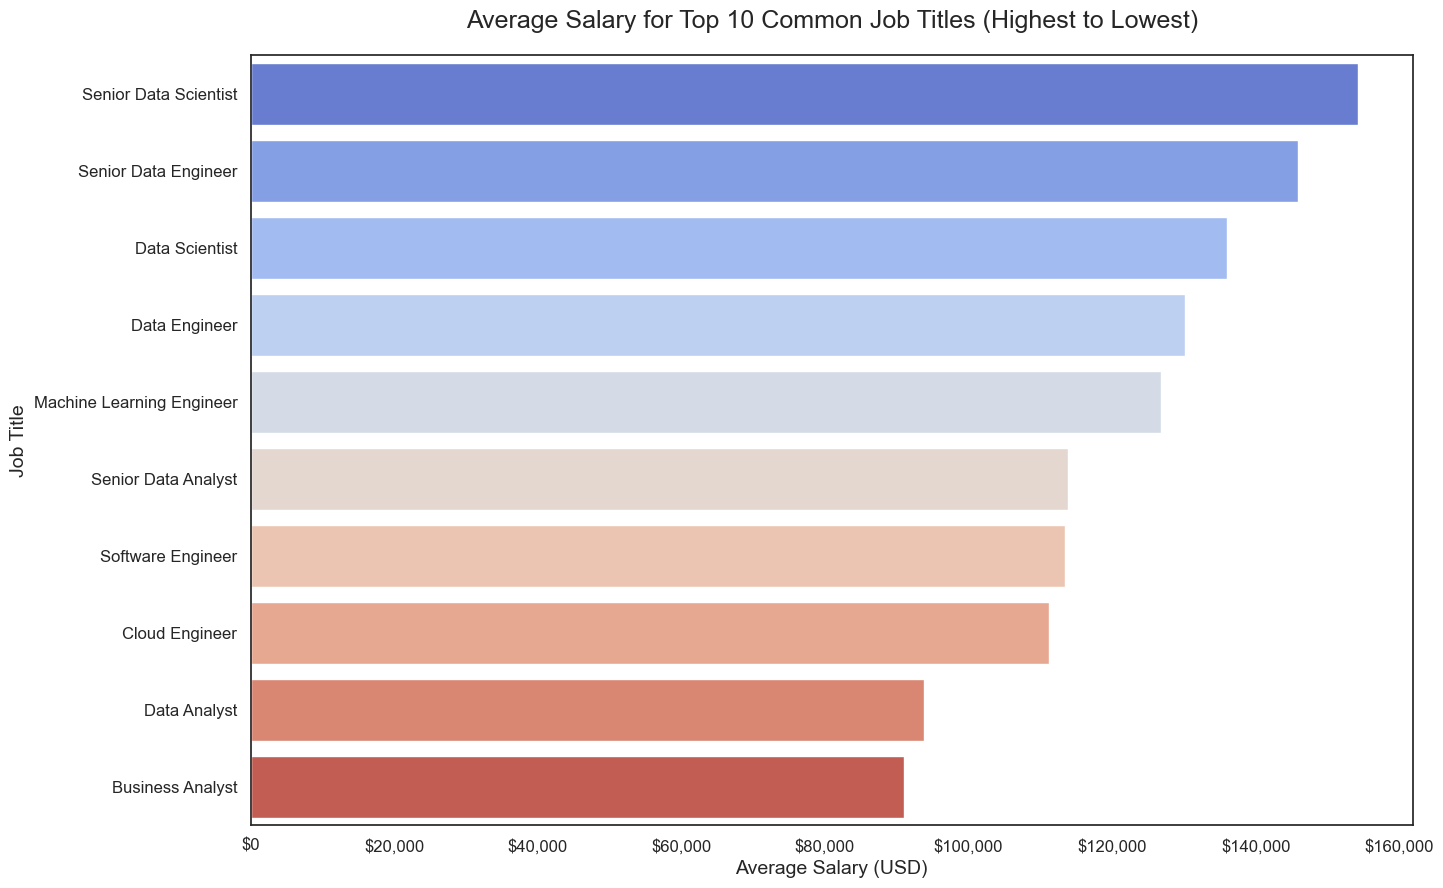

In [ ]:
# Set the theme for visualizations
sns.set_theme(style='white')

# Create a horizontal bar plot for average salaries
plt.figure(figsize=(15, 10))
sns.barplot(
    x=mean_salaries.values,  # Average salary values
    y=mean_salaries.index,  # Job titles
    order=mean_salaries.index,  # Order by average salary (highest to lowest)
    palette='coolwarm'  )

# Add title and labels
plt.title('Average Salary for Top 10 Common Job Titles (Highest to Lowest)', fontsize=18, pad=20)
plt.xlabel('Average Salary (USD)', fontsize=14)
plt.ylabel('Job Title', fontsize=14)

# Format x-axis ticks to include dollar signs and commas
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'${x:,.0f}'))

# Improve tick labels
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Display the plot
plt.show()

## 💰 Salary Distribution: Data Engineer vs Data Scientist vs Data Analyst

Comparing the salary distributions for three key roles: **Data Engineer**, **Data Scientist**, and **Data Analyst**. using a boxplot to visualize the median, quartiles, and outliers in the salary data.

## 📊 1: Filter the dataset to include only relevant roles

In [41]:
# Filter the dataset to include only Data Engineer, Data Scientist, and Data Analyst roles
df_DE_DS_DA = df[df['job_title_short'].isin(['Data Engineer', 'Data Scientist', 'Data Analyst'])].copy()

## 📚 2: Define the order you want the roles to be visualized

In [42]:
# Define the order of job titles for the plot
plot_order = ['Data Engineer', 'Data Scientist', 'Data Analyst']

## 🎨 Visualization : 
this Visualization highlights the Salary Distribution of  Data Engineer, Data Scientist, Data Analyst (*top 3 popular roles in job postings*)

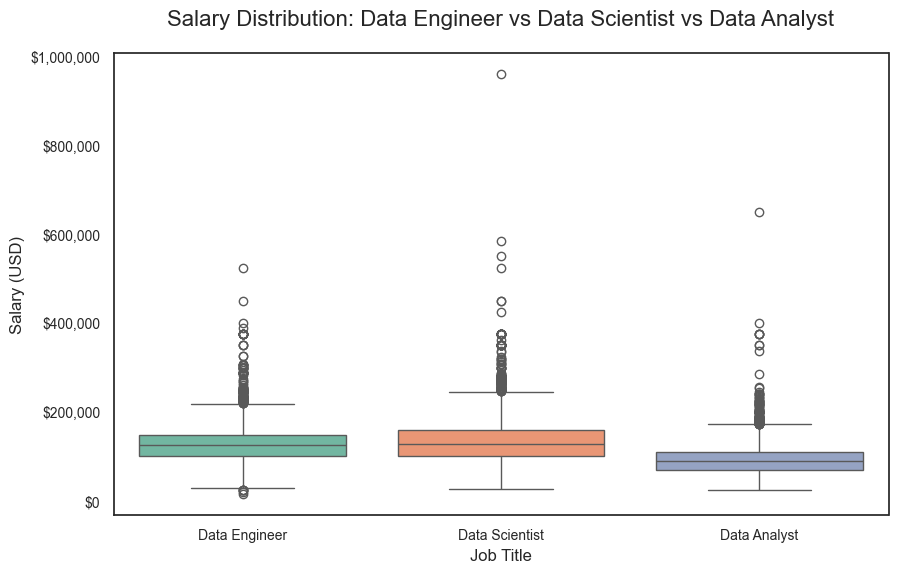

In [ ]:
# Set the theme for visualizations
sns.set_theme(style='white')

# Create a boxplot to compare salary distributions
plt.figure(figsize=(10, 6))
sns.boxplot(
    x='job_title_short',  # Job titles on the x-axis
    y='salary_year_avg',  # Salaries on the y-axis
    data=df_DE_DS_DA,  # Filtered dataset
    order=plot_order,  # Order of job titles
    palette='Set2'  
)

# Add title and labels
plt.title('Salary Distribution: Data Engineer vs Data Scientist vs Data Analyst', fontsize=16, pad=20)
plt.xlabel('Job Title', fontsize=12)
plt.ylabel('Salary (USD)', fontsize=12)

# Format y-axis ticks to show currency
import matplotlib.ticker as ticker
def currency_formatter(x, p):
    return f'${x:,.0f}'  # No decimals, with comma separators and dollar sign

plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(currency_formatter))

# Improve tick labels
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Display the plot
plt.show()

## 🏷️5. Percentage of Job Postings by Location

Analyzing the distribution of job postings by location. calculate the count of job postings for the top 10 locations and visualize the results using a horizontal bar plot with annotations.

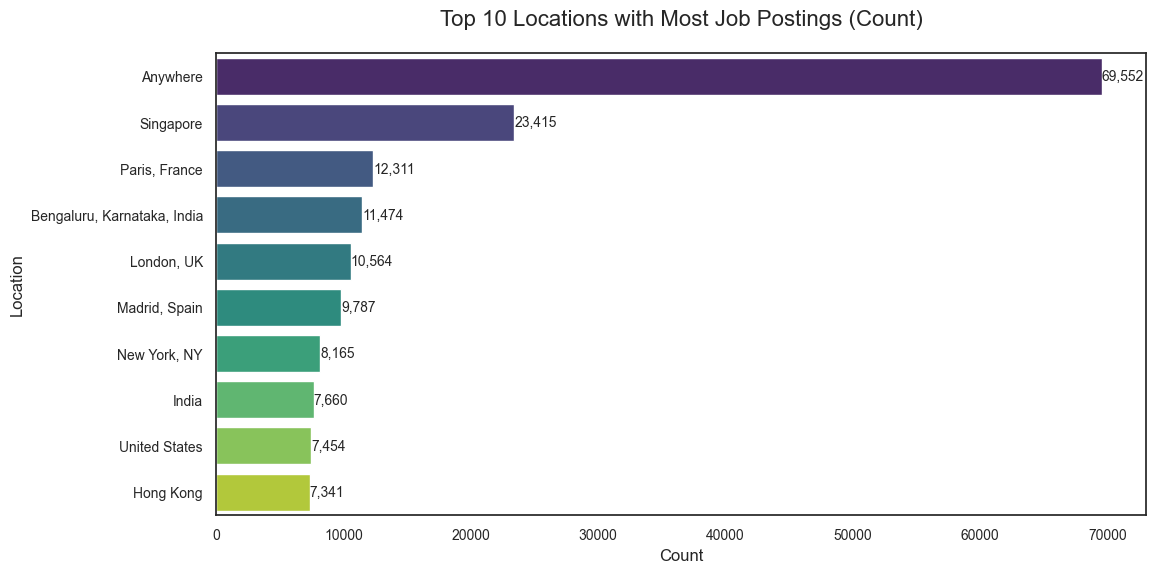

In [ ]:
# Calculate the count of job postings by location
location_counts = df['job_location'].value_counts().head(10)

# Set the theme for visualizations
sns.set_theme(style='white')

# Create a horizontal bar plot for the top 10 locations
plt.figure(figsize=(12, 6))
ax = sns.barplot(
    y=location_counts.index,  # Locations on the y-axis
    x=location_counts.values,  # Counts on the x-axis
    palette='viridis'  # Use the 'viridis' color palette
)

# Add title and labels
plt.title('Top 10 Locations with Most Job Postings (Count)', fontsize=16, pad=20)
plt.xlabel('Count', fontsize=12)
plt.ylabel('Location', fontsize=12)

# Add count annotations to each bar
for i, v in enumerate(location_counts.values):
    ax.text(v + 10, i, f'{v:,}', va='center', fontsize=10)  # Annotate each bar with the count value

# Improve tick labels
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Display the plot
plt.show()

In [ ]:

df_skills = df_DE_DS_DA.explode('job_skills')
skills_count = df_skills.groupby(['job_skills',"job_title_short"]).size()
df_skills_count = skills_count.reset_index(name = 'skill_count')
df_skills_count.sort_values(by = 'skill_count', ascending= False, inplace = True )

df_skills_count


,job_skills,job_title_short,skill_count
471,python,Data Scientist,113711
575,sql,Data Engineer,113130
470,python,Data Engineer,108022
574,sql,Data Analyst,92428
576,sql,Data Scientist,78982
...,...,...,...
306,linode,Data Engineer,1
334,mattermost,Data Scientist,1
359,msaccess,Data Analyst,1
399,nuxt.js,Data Analyst,1


# 📊 Top Skills Analysis by Job Role

Analysis of the most in-demand skills across different job roles in the data field, including Data Engineer, Data Scientist, and Data Analyst positions. 







## 💡 Data Wrangling & Manipulation

For this step, I exploded the 'job_skills' column and aggregated skill counts by job role. This allowed me to calculate the percentage of each skill's demand within the respective job roles.

In [ ]:
# Data Wrangling and Manipulation
df_skills = df_DE_DS_DA.explode('job_skills')
skills_count = df_skills.groupby(['job_skills', 'job_title_short']).size()
df_skills_count = skills_count.reset_index(name='skill_count')
df_skills_count.sort_values(by='skill_count', ascending=False, inplace=True)

# Calculate percentage of skill requirement within each job role
df_skills_count['skill_percent'] = (
    df_skills_count['skill_count'] / df_skills_count.groupby('job_title_short')['skill_count'].transform('sum') * 100
)

df_skills_count.head()

,job_skills,job_title_short,skill_count,skill_percent
471,python,Data Scientist,113711,14.218852
575,sql,Data Engineer,113130,9.976534
470,python,Data Engineer,108022,9.526077
574,sql,Data Analyst,92428,14.536544
576,sql,Data Scientist,78982,9.876207


## 📈 Visualization: Top Skills by Job Role

The visualization highlights the top 5 most requested skills within each job role. The percentage of job postings requiring each skill is displayed, with dynamic x-axis scaling for better clarity.

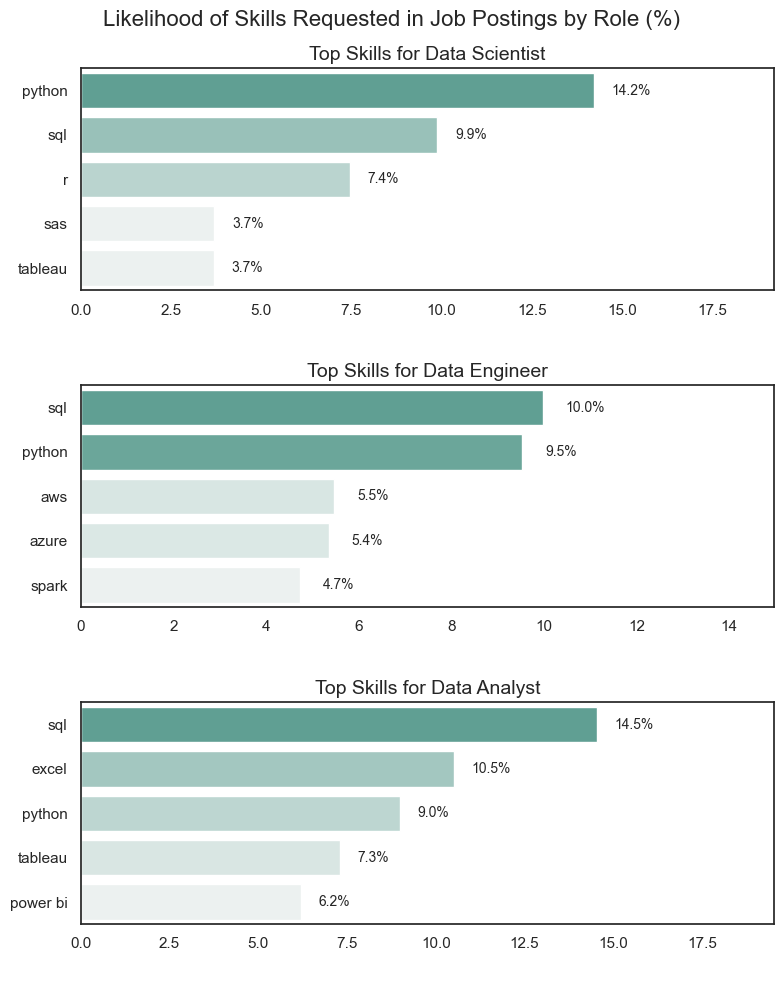

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style='white')
job_titles = df_skills_count['job_title_short'].unique()
fig, ax = plt.subplots(len(job_titles), 1, figsize=(8, 10))
sns.set_theme(style='ticks')

for i, job_title in enumerate(job_titles):
    df_plot = df_skills_count[df_skills_count['job_title_short'] == job_title].head(5)
    sns.barplot(
        data=df_plot,
        x='skill_percent',
        y='job_skills',
        ax=ax[i],
        hue='skill_count',
        palette='light:#5A9'
    )
    ax[i].set_title(f"Top Skills for {job_title}", fontsize=14)
    ax[i].set_ylabel('')
    ax[i].set_xlabel(' ')
    ax[i].legend().set_visible(False)
    max_x = df_plot['skill_percent'].max() + 5
    ax[i].set_xlim(0, max_x)
    for n, v in enumerate(df_plot['skill_percent']):
        ax[i].text(v + 0.5, n, f'{v:.1f}%', va='center', fontsize=10)

fig.suptitle('Likelihood of Skills Requested in Job Postings by Role (%)', fontsize=16)
fig.tight_layout(h_pad=1.5)
plt.show()

# 📊 Top 10 Job Postings: Africa vs. Non-Africa

In this section, we analyze the likelihood of the top 10 most commonly posted jobs appearing in African and non-African countries.

## 🚦1: Identify the Top 10 Most Commonly Posted Jobs

In [14]:
# Step 1: Identify the Top 10 Most Commonly Posted Jobs
top_10_jobs = df['job_title'].value_counts().head(10)

## Generate a list of African Countries

In [15]:
# Get unique job locations
unique_countries = df['job_country'].unique()

# Display the unique locations
#print(locations)

# List of African countries for comparison
african_countries = [
    'Algeria', 'Angola', 'Benin', 'Botswana', 'Burkina Faso', 'Burundi',
    'Cabo Verde', 'Cameroon', 'Central African Republic', 'Chad', 'Comoros',
    'Congo, Democratic Republic of the', 'Congo, Republic of the', 'Côte d\'Ivoire',
    'Djibouti', 'Egypt', 'Equatorial Guinea', 'Eritrea', 'Eswatini', 'Ethiopia',
    'Gabon', 'Gambia', 'Ghana', 'Guinea', 'Guinea-Bissau', 'Kenya', 'Lesotho',
    'Liberia', 'Libya', 'Madagascar', 'Malawi', 'Mali', 'Mauritania', 'Mauritius',
    'Morocco', 'Mozambique', 'Namibia', 'Niger', 'Nigeria', 'Rwanda', 'Sao Tome and Principe',
    'Senegal', 'Seychelles', 'Sierra Leone', 'Somalia', 'South Africa', 'South Sudan',
    'Sudan', 'Tanzania', 'Togo', 'Tunisia', 'Uganda', 'Zambia', 'Zimbabwe'
]

# Extract African countries present in the dataset
african_countries_in_data = [country for country in unique_countries if country in african_countries]
print("African countries in the dataset:", african_countries_in_data)


African countries in the dataset: ['Sudan', 'Namibia', 'Egypt', 'South Africa', 'Nigeria', 'Lesotho', 'Mauritius', "Côte d'Ivoire", 'Tunisia', 'Kenya', 'Senegal', 'Ghana', 'Morocco', 'Guinea', 'Uganda', 'Ethiopia', 'Liberia', 'Burkina Faso', 'Benin', 'Zambia', 'Cameroon', 'Togo', 'Rwanda', 'Algeria', 'Congo, Democratic Republic of the', 'Zimbabwe', 'Mozambique', 'Tanzania', 'Madagascar', 'Mali', 'Malawi', 'Libya', 'Mauritania', 'Botswana', 'Angola', 'Somalia', 'Gambia', 'Djibouti']


## 🌍2: Split Data into African and Non-African Locations

In [16]:
# Split Data into African and Non-African Locations
african_data = df[df['job_country'].isin(african_countries_in_data)]
non_african_data = df[~df['job_country'].isin(african_countries_in_data)]

## 📈3: Count Job Postings in Each Region

In [17]:
# Count Job Postings in Each Region
african_job_counts = african_data['job_title'].value_counts()
non_african_job_counts = non_african_data['job_title'].value_counts()

## 🔍4: Calculate Job Likelihood in Africa vs. Non-Africa

In [18]:
# Calculate the Likelihood of Each Top 10 Job in African vs. Non-African Countries
likelihood_comparison = pd.DataFrame({
    'Job Title': top_10_jobs.index,
    'Global Count': top_10_jobs.values,
    'Africa Count': [african_job_counts.get(job, 0) for job in top_10_jobs.index],
    'Non-Africa Count': [non_african_job_counts.get(job, 0) for job in top_10_jobs.index],
})

# Calculate the likelihood percentages
likelihood_comparison['Africa Likelihood (%)'] = (
    (likelihood_comparison['Africa Count'] / likelihood_comparison['Global Count']) * 100
)
likelihood_comparison['Non-Africa Likelihood (%)'] = (
    (likelihood_comparison['Non-Africa Count'] / likelihood_comparison['Global Count']) * 100
)

likelihood_comparison

,Job Title,Global Count,Africa Count,Non-Africa Count,Africa Likelihood (%),Non-Africa Likelihood (%)
0,Data Engineer,53908,3372,50536,6.255101,93.744899
1,Data Scientist,42542,3429,39113,8.060270,91.939730
2,Data Analyst,41950,1680,40270,4.004768,95.995232
3,Senior Data Engineer,20217,1389,18828,6.870456,93.129544
4,Senior Data Scientist,13335,1081,12254,8.106487,91.893513
5,Senior Data Analyst,8209,289,7920,3.520526,96.479474
6,Lead Data Engineer,3914,269,3645,6.872764,93.127236
7,Lead Data Scientist,3322,247,3075,7.435280,92.564720
8,Azure Data Engineer,3307,138,3169,4.172966,95.827034
9,Machine Learning Engineer,3097,163,2934,5.263158,94.736842


## 🎨 Visualization: Job Likelihood by Region

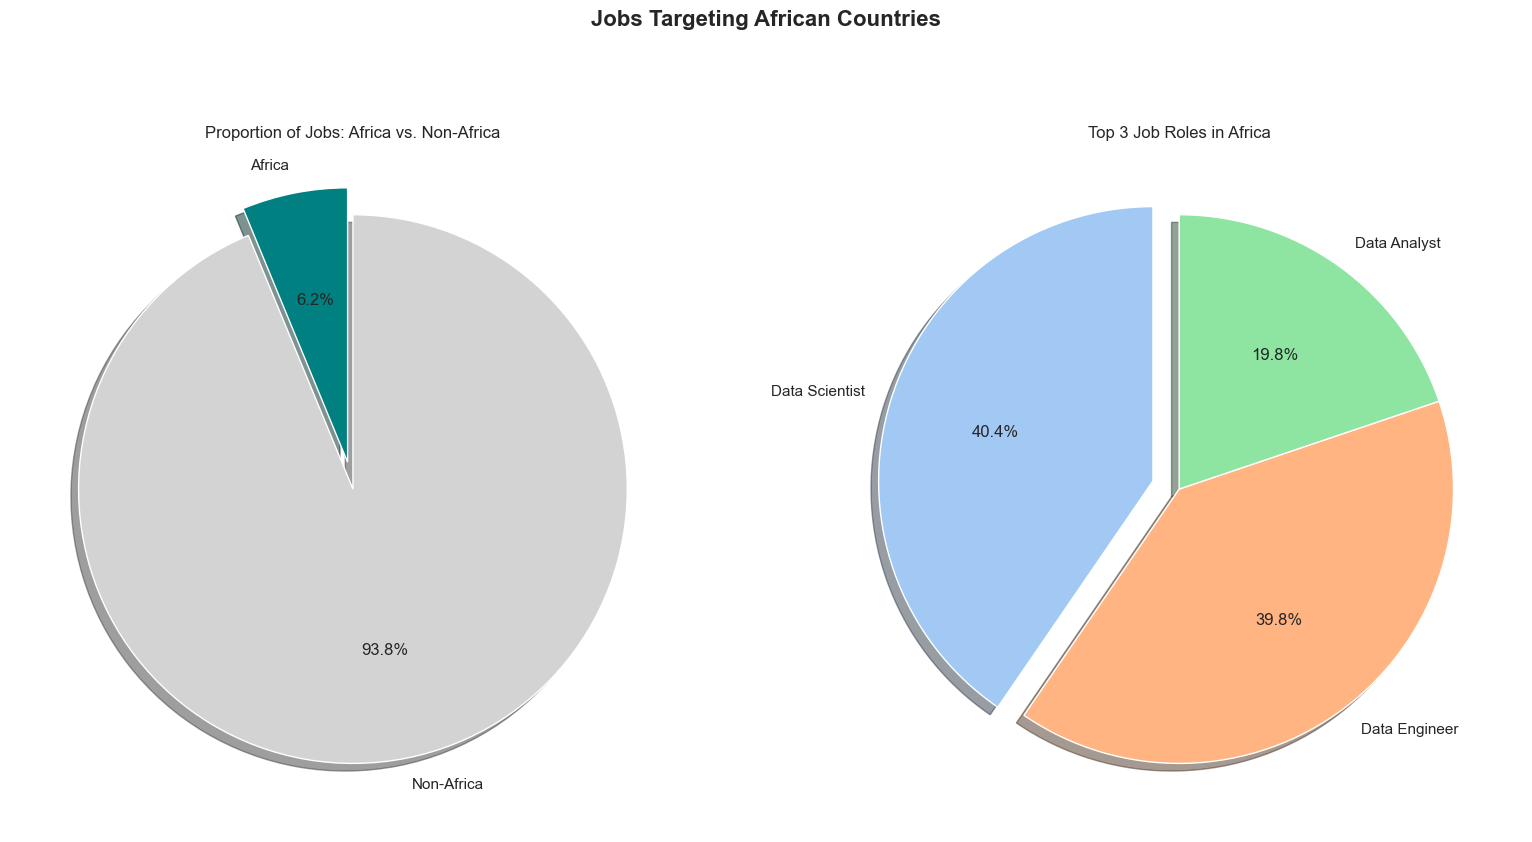

In [22]:

# Set the style for better visuals using seaborn directly
sns.set_theme(style='darkgrid')

# Create a figure with subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Plot 1: Proportion of Jobs in Africa vs. Non-Africa
total_africa_jobs = likelihood_comparison['Africa Count'].sum()
total_non_africa_jobs = likelihood_comparison['Non-Africa Count'].sum()

axes[0].pie([total_africa_jobs, total_non_africa_jobs], labels=['Africa', 'Non-Africa'], autopct='%1.1f%%', colors=['teal', 'lightgrey'], startangle=90, explode=[0.1, 0], shadow=True)
axes[0].set_title('Proportion of Jobs: Africa vs. Non-Africa')

# Plot 2: Top 3 Most Common Jobs in Africa (Pie Chart)
top_3_african_jobs = likelihood_comparison.nlargest(3, 'Africa Count')

axes[1].pie(top_3_african_jobs['Africa Count'], labels=top_3_african_jobs['Job Title'], autopct='%1.1f%%', colors=sns.color_palette('pastel')[:3], startangle=90, explode=[0.1, 0, 0], shadow=True)
axes[1].set_title('Top 3 Job Roles in Africa')

plt.suptitle('Jobs Targeting African Countries', fontsize=16, fontweight='bold', y=1.05)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


## 🌍 Where Are African Jobs Coming From?
This section of the analysis focuses on identifying the top companies contributing to job opportunities in African countries.

## 📊 Top Companies Posting Jobs in Africa

In [27]:
# Where are African Jobs Comming from ?
african_jobs = df[df['job_country'].isin(african_countries_in_data)]

# Getting the top companies with the most job postings in Africa
top_african_companies = african_jobs['company_name'].value_counts().head(10)

print("Top Companies Posting Jobs in Africa:\n", top_african_companies)


Top Companies Posting Jobs in Africa:
 company_name
E-Merge                536
Upwork                 435
Walmart                390
Dice                   331
findojobs-za           322
Capital One            265
Confidential           214
Booz Allen Hamilton    210
Network Recruitment    205
SynergisticIT          205
Name: count, dtype: int64


## 🎨 Visualization: Company Job Postings Targeting Africa

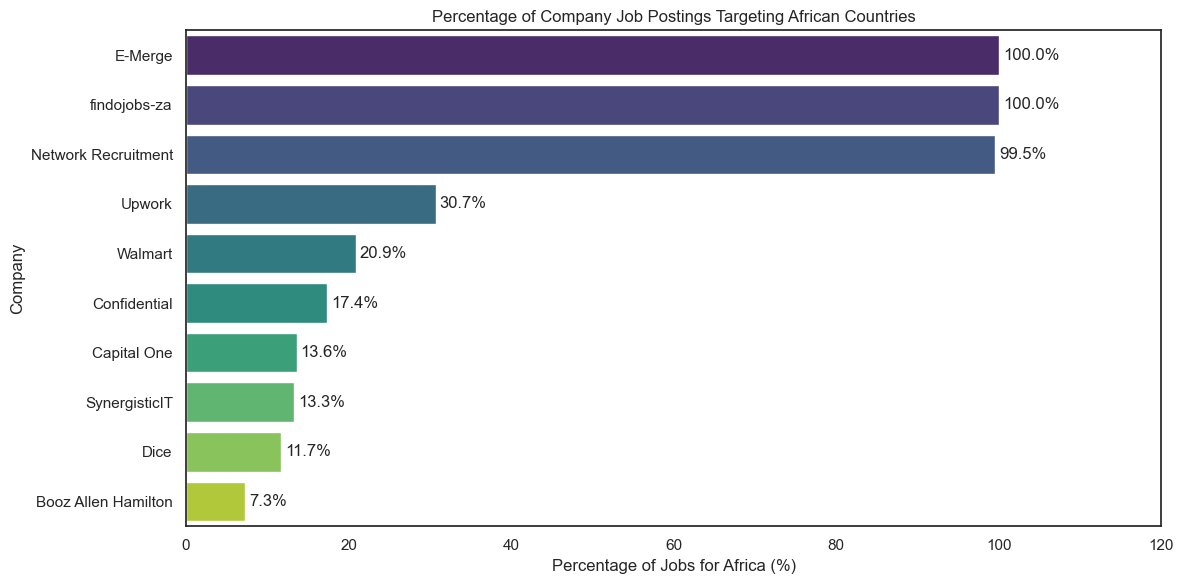

In [28]:

# Ensure consistent styling
sns.set_theme(style='white')

# Calculate total global job postings for the top African companies
global_company_counts = df['company_name'].value_counts().loc[top_african_companies.index]

# Calculate the percentage of African job postings
african_job_counts = top_african_companies
african_job_percentages = (african_job_counts / global_company_counts * 100).round(1)

# Sort by African job counts (descending)
african_job_percentages = african_job_percentages.sort_values(ascending=False)

# Visualization: Bar Chart with Percentage Annotations
plt.figure(figsize=(12, 6))
ax = sns.barplot(
    y=african_job_percentages.index, 
    x=african_job_percentages.values, 
    palette='viridis'
)

plt.title('Percentage of Company Job Postings Targeting African Countries')
plt.xlabel('Percentage of Jobs for Africa (%)')
plt.ylabel('Company')
plt.xlim(0, 120)


# Add percentage annotations to each bar
for i, v in enumerate(african_job_percentages.values):
    ax.text(v + 0.5, i, f'{v:.1f}%', va='center')

plt.tight_layout()
plt.show()


## 📅 Trend Analysis of Job Postings by Month

This analysis explores the trend of job postings over time to identify seasonal patterns or fluctuations in job availability.

## ⏰ 1: Prepare the Date Data

In [31]:
# Assuming df['job_posted_date'] contains job posting job_posted_dates
df['job_posted_date'] = pd.to_datetime(df['job_posted_date'])

# Extract the month and year from the job_posted_date
df['month_year'] = df['job_posted_date'].dt.to_period('M')


## 📈 2: Count Job Postings by Month

In [32]:
# Count job postings by month
monthly_postings = df['month_year'].value_counts().sort_index()


## 🎨 Visualization: Trend of Job Postings Per Month

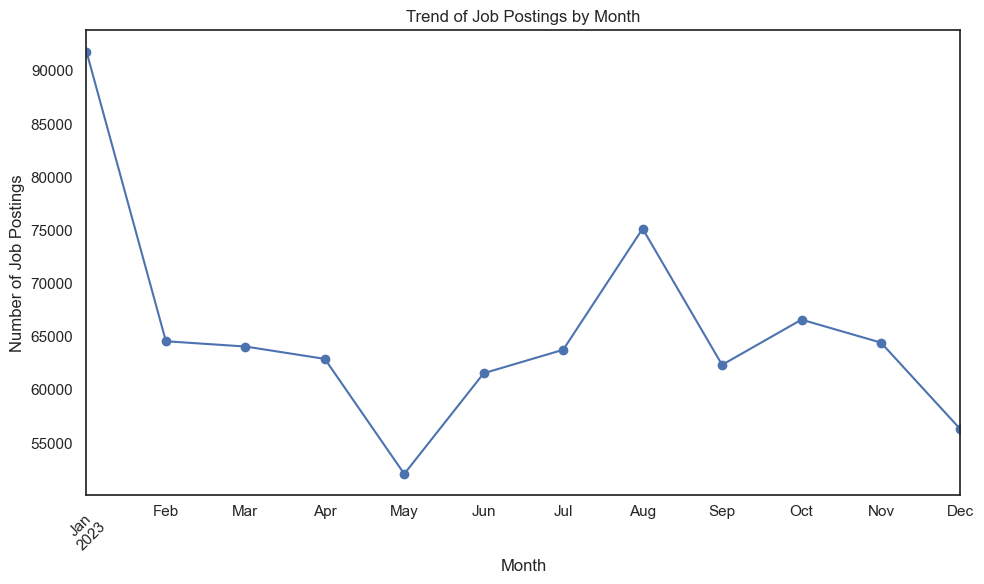

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the visual theme
sns.set_theme(style='white')

# Plotting the trend of job postings per month
plt.figure(figsize=(10, 6))
monthly_postings.plot(kind='line', marker='o')
plt.title('Trend of Job Postings by Month')
plt.xlabel('Month')
plt.ylabel('Number of Job Postings')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()